## Objective: Peform image classification with pre-trained CNN model with new classification head

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [7]:
print("=== GPU ===")
!nvidia-smi
print("\n=== CPU & RAM ===")
import psutil
print(f"CPU %: {psutil.cpu_percent()}")
print(f"RAM %: {psutil.virtual_memory().percent}")

=== GPU ===
Thu Nov 20 06:56:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------

In [5]:
from glob import glob
glob("./*")

['./sample_data']

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:',device)

Device is: cpu


## Load CIFAR-100 Dataset

In [29]:
transform = models.MobileNet_V3_Small_Weights.DEFAULT.transforms()


dataset_root = '../../datasets/cv/'
train_dataset_ = torchvision.datasets.CIFAR100(root=dataset_root, train = True, download = True, transform = transform)
test_dataset = torchvision.datasets.CIFAR100(root=dataset_root, train = False, download = True, transform = transform)

In [30]:
targets = np.array(train_dataset_.targets)
print(f'  {"Name":10s} Count')
for ix in range(targets.max()):
  print(f'{ix} {train_dataset_.classes[ix]:10s} {sum(targets == ix)}')
print()
# The data is stored in a tensor with the following dimensions
print(f'Dimensions of training dataset tensor:\n\t{train_dataset_.data.shape}\n')
print(f'Dimensions of testing dataset tensor:\n\t{test_dataset.data.shape}')
print()
print(f'Dataset target labels:\n\t{train_dataset_.classes}\n')
print(f'Dataset target dimensions:\n\t{len(train_dataset_.targets)}')
print()
print(f'Max value: {train_dataset_.data.max()}')
print(f'Min value: {train_dataset_.data.min()}')

  Name       Count
0 apple      500
1 aquarium_fish 500
2 baby       500
3 bear       500
4 beaver     500
5 bed        500
6 bee        500
7 beetle     500
8 bicycle    500
9 bottle     500
10 bowl       500
11 boy        500
12 bridge     500
13 bus        500
14 butterfly  500
15 camel      500
16 can        500
17 castle     500
18 caterpillar 500
19 cattle     500
20 chair      500
21 chimpanzee 500
22 clock      500
23 cloud      500
24 cockroach  500
25 couch      500
26 crab       500
27 crocodile  500
28 cup        500
29 dinosaur   500
30 dolphin    500
31 elephant   500
32 flatfish   500
33 forest     500
34 fox        500
35 girl       500
36 hamster    500
37 house      500
38 kangaroo   500
39 keyboard   500
40 lamp       500
41 lawn_mower 500
42 leopard    500
43 lion       500
44 lizard     500
45 lobster    500
46 man        500
47 maple_tree 500
48 motorcycle 500
49 mountain   500
50 mouse      500
51 mushroom   500
52 oak_tree   500
53 orange     500
54 orchid     5

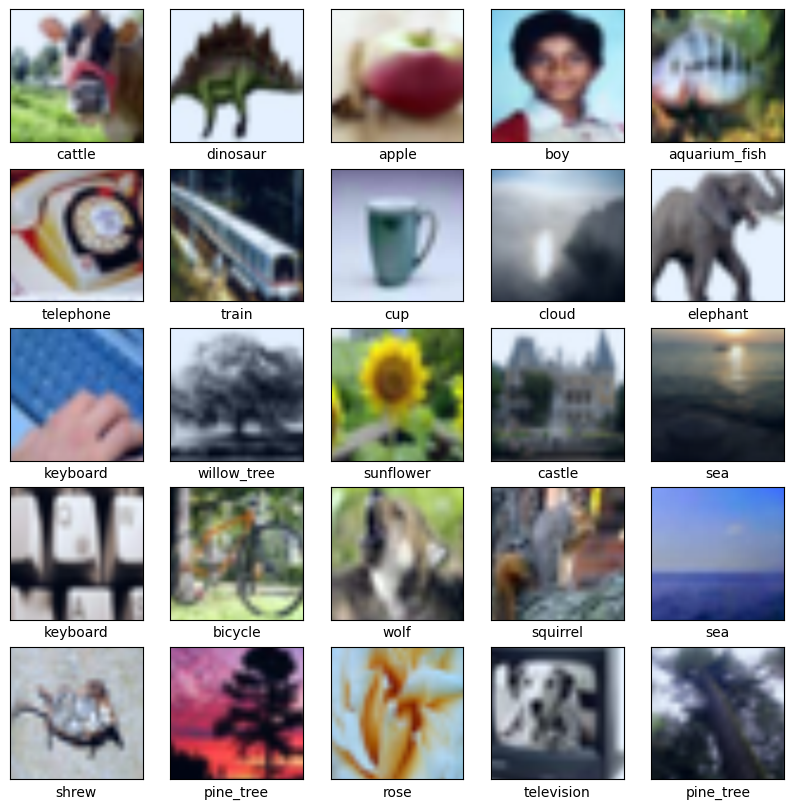

In [31]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = train_dataset_[i][0].permute(1,2,0)
    img = img - img.min()
    img = img / img.max()
    plt.imshow(img, cmap=plt.cm.gray)
    plt.xlabel(train_dataset_.classes[train_dataset_[i][1]])

## Set up data subsets

In [32]:
train_size = int(0.8 * len(train_dataset_))
val_size = len(train_dataset_) - train_size

train_dataset, val_dataset = random_split(train_dataset_, [train_size, val_size])

In [33]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Use pretrained CNN Model

In [34]:
pre_trained_model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

num_features = pre_trained_model.classifier[0].in_features

pre_trained_model.classifier = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.GELU(),
        nn.Dropout(0.3),
        nn.Linear(256, 100)
    )

pre_trained_model = pre_trained_model.to(device)

## Set up Training parameters

In [35]:
training_epochs = 100
learning_rate = 3e-4

In [36]:
def check_performance(model, loss, loader, device):
  losses = []
  all_preds = []
  all_targets = []

  #The eval mode and torch.no_grad are called to avoid computing things not
  # required for a forward pass, like gradient computations
  model.eval()
  with torch.no_grad():
    for features, target in loader:
      predictions = model(features.to(device))
      error = loss(predictions, target.to(device))
      losses.append(error.item())

      preds = predictions.argmax(axis=1)
      all_preds.append(preds)
      all_targets.append(target)

  return {'losses': losses,
          'predictions': torch.hstack(all_preds).cpu(),
          'targets': torch.hstack(all_targets).cpu()
          }

## Fine Tune CNN Model

In [37]:
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(pre_trained_model.parameters(), lr=learning_rate,weight_decay=1e-4)

In [38]:
stats_per_epoch = {
  'train_loss': [],
  'train_accuracy': [],
  'val_loss': [],
  'val_accuracy': []
  }

best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
epochs_no_improve = 0
early_stop = False

pre_trained_model.train()  # Put model in train mode so it tracks gradients, etc. for optimization
for i in range(training_epochs):
  if early_stop:
        print("Early stopping triggered!")
        break
      
  print(f'Epoch: {i}')
  train_losses = []
  train_correct = 0
  train_total = 0

  for features, target in tqdm(train_loader):
    optimizer.zero_grad()                       # do not accumulate gradients

    features = features.to(device)
    target = target.to(device)

    predictions = pre_trained_model(features)               # forward pass
    error = loss(predictions, target)           # compute loss
    train_losses.append(error.item())

    _, predicted = torch.max(predictions.data, 1)
    train_total += target.size(0)
    train_correct += (predicted == target).sum().item()

    error.backward()                            # backward pass
    optimizer.step()                            # update weights

  # Per epoch stats
  stats_per_epoch['train_loss'].append(np.mean(train_losses))
  stats_per_epoch['train_accuracy'].append(train_correct / train_total)
  perf = check_performance(pre_trained_model, loss, val_loader, device)
  current_val_loss = np.mean(perf['losses'])  
  current_val_acc = (sum(perf['targets'] == perf['predictions']) / len(perf['targets'])).item()

  stats_per_epoch['val_loss'].append(current_val_loss)
  stats_per_epoch['val_accuracy'].append(current_val_acc)

  print(f'\tMean train loss: {stats_per_epoch["train_loss"][-1]:.3f}')
  print(f'\tMean validation loss: {current_val_loss:.3f}')
  print(f'\tMean train accuracy: {stats_per_epoch["train_accuracy"][-1]:.3f}')
  print(f'\tMean validation accuracy: {current_val_acc:.3f}')
  
  # EARLY STOPPING
  if current_val_loss < best_val_loss:
      best_val_loss = current_val_loss
      epochs_no_improve = 0
  else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
          early_stop = True
  

# End of run stats
test_perf = check_performance(pre_trained_model, loss, test_loader, device)
stats_per_epoch['test_loss'] = np.mean(test_perf['losses'])
stats_per_epoch['test_accuracy'] = (sum(test_perf['targets'] == test_perf['predictions']) / len(test_perf['targets'])).item()

print(f'Mean test loss: {stats_per_epoch["test_loss"]:.3f}')
print(f'Mean test accuracy: {stats_per_epoch["test_accuracy"]:.3f}')

Epoch: 0


 29%|██▉       | 92/313 [00:30<01:13,  2.99it/s]


KeyboardInterrupt: 

## Results

In [ ]:
epochs = range(len(stats_per_epoch['train_loss']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(epochs, stats_per_epoch['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, stats_per_epoch['val_loss'], 'r-', label='Validation Loss')

last_epoch = len(epochs) - 1
ax1.plot(last_epoch, stats_per_epoch['test_loss'], 'ro', label='Test Loss')  

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Epoch')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, stats_per_epoch['train_accuracy'], 'b-', label='Train Accuracy')
ax2.plot(epochs, stats_per_epoch['val_accuracy'], 'r-', label='Validation Accuracy')

ax2.plot(last_epoch, stats_per_epoch['test_accuracy'], 'ro', label='Test Accuracy')  

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def visualize(dataset, stats, errors = None):
  if errors is None:
    errors = []
    print('Correct Label in ()')
  else:
    print(f'Errors where true label is {dataset.classes[stats["targets"][errors[0]]]}')

  plt.figure(figsize=(10,10))
  for i in range(min(len(errors), 25) if len(errors) else 25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      j = errors[i] if len(errors) else i

      img = dataset[j][0].permute(1,2,0)
      img = img - img.min()
      img = img / img.max()
      plt.imshow(img, cmap=plt.cm.gray)
      predicted_label = stats['predictions'][j]
      true_label = stats['targets'][j]
      if predicted_label == true_label:
        color = 'green'
      else:
        color = 'red'
      plt.xlabel("{} ({})".format(dataset.classes[predicted_label],
                                  dataset.classes[true_label]),
                                  color=color)
      
visualize(test_dataset, test_perf)

In [ ]:
true_class_ix = 3 
errors = np.where(test_perf['targets'] != test_perf['predictions'])[0]
e2 = np.where(test_perf['targets']==true_class_ix)[0]
errors = np.intersect1d(e2,errors)

visualize(test_dataset, test_perf, errors)